# Part 2. 컴퓨터에게 그리기, 글쓰기, 작곡하기, 게임을 가르친다.

# chapter 05 그리기

지금까지 본 모든 예제는 완전히 새로운 샘플을 생성하는 것이었다. 즉, 어떤 입력도 없이 잠재공간에서 랜덤하게 샘플링한 벡터를 이용해 이미지를 생성하는 것이다.

이번에 볼 생성 모델 애플리케이션은 **스타일 트랜스퍼(style transfer)** 이다. 주된 목적은 스타일 이미지가 주어졌을 때 같은 부류에 속한 것 같은 느낌을 주도록 베이스 이미지를 변환하는 모델을 훈련하는 것이다. 다음 그림에 몇 개의 예시가 있다.

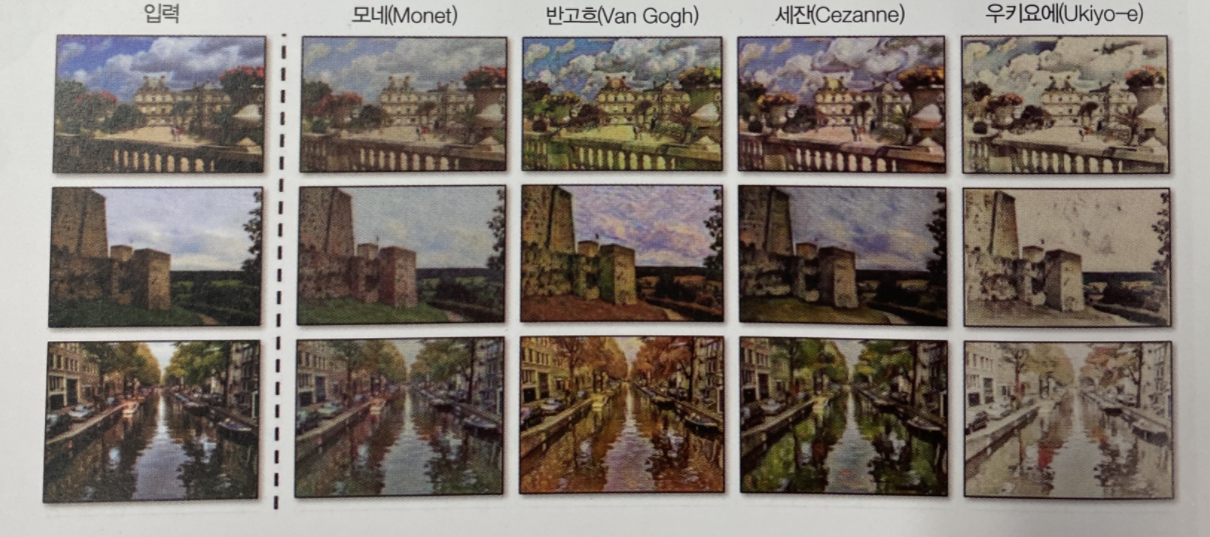

- 스타일 트랜스퍼는 스타일 이미지에 내재된 분포를 모델링하는 것이 아니라 **이미지에서 스타일을 결정하는 요소만 추출하여 베이스 이미지에 주입하는 것**이다( 스타일 이미지와 베이스 이미지를 보간 방법으로 합쳐서는 안 된다 )


- 또한 하나의 이미지를 사용하는 것이 아니라 스타일 이미지 세트 전체에서 아티스트의 스타일을 잡아낸다. 따라서 모델이 전체 이미지 세트에 걸쳐 사용된 스타일을 학습하기 위한 방법을 찾아야한다.

**이 장에서는 두 종류의 스타일 트랜스퍼 모델(CycleGAN , 뉴럴 스타일 트랜스퍼)을 만드는 방법을 배우고 이 기법을 사진과 그림에 적용해보자.**

# 5.2 CycleGAN 소개

- 이 논문은 스타일 트랜스퍼 분야에서 큰 진전을 이루어낸 것으로 평가된다.


- **샘플 쌍으로 구성된 훈련 세트 없이도 참조 이미지 세트의 스타일을 다른 이미지로 복사하는 모델을 훈련할 수 있는 방법을 보였다.**


- pix2pix같은 이전의 스타일 트랜스퍼는 훈련 세트의 각 이미지가 소스(source)와 타깃(target) 도메인에 모두 존재해야한다.


- CycleGAN은 pix2pix가 발표된지 불과 몇 달 만에 공개되어 소스와 타깃 도메인에 이미지 쌍 없이 어떻게 모델을 훈련하는지 선보였다.


- pix2pix는 한방향으로(소스에서 타깃으로)만 작동하지만 CycleGAN은 양방향으로 동시에 모델을 훈련한다 => 따라서 모델이 소스에서 타깃으로 뿐만 아니라 타깃에서 소스로 이미지를 변환할 수 있다.


# 5.3 첫 번째 CycleGAN

## 5.3.1 개요

CycleGAN은 실제 네 개의 모델로 구성된다.**두 개의 생성자**와 **두 개의 판별자**가 있다.

   - 첫 번째 **생성자** g_AB는 도메인 A의 이미지를 도메인 B로 바꾼다.
   
   - 두 번째 **생성자** g_BA는 도메인 B의 이미지를 도메인 A로 바꾼다.

생성자는 훈련을 위한 이미지 쌍이 없기 때문에 생성자가 만든 이미지가 설득력이 있는지 결정하는 두 개의 판별자를 훈련한다.

   - 첫 번째 **판별자** d_A는 도메인 A의 진짜 이미지와 생성자 g_BA가 만든 가짜 이미지를 구별할 수 있도록 훈련된다.
   
   - 두 번째 **판별자** d_B는 도메인 B의 진짜 이미지와 생성자 g_AB가 만든 가짜 이미지를 구별할 수 있도록 훈련된다.


In [ ]:
# CycleGAN 정의

gan = CycleGAN(input_dim = (128,128,3), learning_rate = 0.0002, lambda_validation = 1, lambda_reconstr=10, lambda_id = 2,
              generator_type = 'u-net',gen_n_filters=32, disc_n_filters=32)

## 5.3.2 생성자(U-Net)

일반적으로 **CycleGAN 생성자**는 **U-Net** 또는 **ResNet(residual network)** 두 형태 중 하나를 선택한다.

pix2pix 논문에서 저자들은 U-Net 구조를 사용했지만 CycleGAN에서는 ResNet구조로 바꾸었다. 

이 장에서는 두 구조를 모두 만들어 볼 것이다.

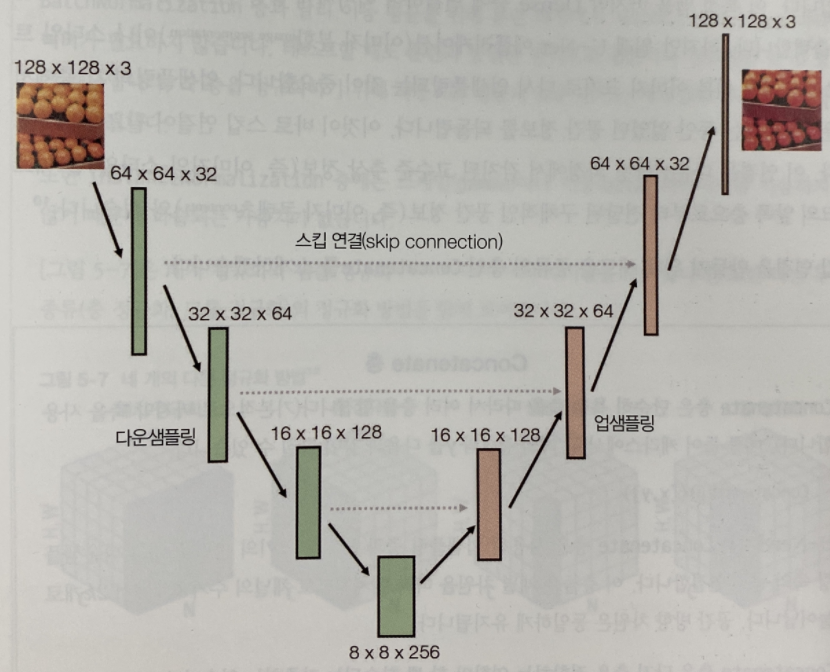

위의 그림은 앞으로 사용할 U-Net의 구조를 보여준다. 


- VAE와 비슷한 방식인 U-Net은 다운샘플링과 업샘플링으로 구성된다. 
    
    **다운샘플링** : 입력 이미지를 공간 방향으로 압축하지만 , 채널 방향으로는 확장한다.
    
    **업샘플링** : 공간 방향으로 표현을 확장시키는 반면 채널의 수는 감소시킨다.
    
   
- 하지만 VAE와 달리 U-Net 네트워크의 다운샘플링과 업샘플링 사이에는 크기가 동일한 층끼리 연결된 **스킵 연결(skip connection)** 이 있다.


- VAE는 선형적으로 데이터가 입력에서부터 출력까지 층을 차례대로 거쳐 네트워크를 통과하지만 U-Net은 스킵 연결이 있기 때문에 네트워크에 있는 지름길로 뒤쪽 층에 정보를 전달한다.


- 네트워크의 다운샘플링에 각 층 모델은 점점 이미지가 무엇인지를 감지하지만 어디에 있는지 위치 정보는 잃는다. U-Net의 꼭짓점에 있는 특성 맵은 이미지가 무엇인지 이해할 수 있지만 어디에 있는지는 거의 알지 못할 것이다.


- 이 특성 맵을 마지막 Dense층에 연결하여 이미지에 등장하는 특정 클래스의 확률을 출력한다. 하지만 원래 U-Net 애플리케이션이나 스타일 트랜스퍼에서는 원본 이미지 크기로 다시 업샘플링되는 것이 중요하다.

    => 이것이 스킵 연결이 필요한 이유. 이 연결은 다운샘플링 과정에서 감지된 고수준 추상정보(즉, 이미지 스타일)를 네트워크 앞쪽 층으로부터 전달된 구체적인 공간정보(즉, 이미지 컨텐츠)와 섞는다.

스킵 연결을 만들기 위해 새로운 종류의 층인 Concatenate에 대해 알아보자.

- Concatenate층이란 ? 

    단순히 특정 축을 따라서 여러층을 합친다. 예를 들어 케라스에서 두 개의 층 x와 y를 다음과 같이 합칠 수 있다.

    => Concatenate()([x,y])
    
    U-Net에서는 Concatenate층을 사용해 업샘플링 층과 동일한 크기의 출력을 내는 다운샘플링 쪽의 층을 연결한다. 이 층들은 채널 차원을 따라 합쳐지므로 채널의 수가 k개에서 2k개로 늘어나며 공간 방향 차원은 동일하게 유지된다.
    
    **Concatenate층은 단지 층을 접합하는 역할만 할 뿐 학습되는 가중치는 없다.**

이 생성자는 InstanceNormalization이라는 또 다른 새로운 층을 포함한다.

- InstanceNormalization층(샘플 정규화)

    CycleGAN의 생성자는 BatchNormalization층 대신 InstanceNormalization층을 사용한다(이 층이 스타일 트랜스퍼 문제에서 더 만족스러운 결과를 낸다).
    
    InstanceNormalization층은 배치 단위가 아니라 개별 샘플을 정규화한다. BatchNormalization층과 달리 이동 평균을 위해 훈련 과정에서 계산하는 mu와 sigma파라미터가 필요하지 않다.
    
    **각 층을 정규화 하기 위해 사용되는 평균과 표준 편차는 채널별로 나누어 샘플로 계산된다.**
    
    또한 InstanceNormalization층에는 스케일(gamma)나 이동(beta)파라미터를 사용하지 않기 때문에 학습되는 가중치가 없다.

In [ ]:
# U-Net 생성자 만들기

def build_generator_unet(self):
    
    def donwsample(layer_input,filters,f_size=4):
        d = Conv2D(filters,kernel_size=f_size,strides=2,padding='same')(input_layer)
        d = InstanceNormalization(axis=-1,center=False,scale = False)(d)
        d = Actication('relu')(d)
        
        return d
    
    def upsample(layer_input,skip_input,filters,f_size=4,dropout_rate=0):
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters,kernel_size=f_size,strides=1,padding='same')(u)
        u = InstanceNormalization(axis=-1,center=False,scale=False)(u)
        u = Activation('relu')(u)
        if dropout_rate :
            u = Dropout(dropout_rate)(u)
        u = Concatenate()[u,skip_intput]
        return u
    
    img = Input(shape=self.img_shape)  # 이미지 입력
    
    # 다운샘플링
    d1=downsample(img,self.gen_n_filters)
    d2=downsample(d1,self.gen_n_filters *2)
    d3=downsample(d2self.gen_n_filters *4)
    d4=downsample(d3,elf.gen_n_filters *8)
    
    # 업샘플링
    u1 = upsample(d4,d3, self.gen_n_filters *4)
    u2= upsample(u1,d2, self.gen_n_filters *2)
    u3= upsample(u2,d1, self.gen_n_filters)
    u4= UpSampling2D(size=2)(u3)
    
    output = Conv2D(self.channels,kernel_size = 4, strides=1,padding='same',activation='tahn')(u4)
    
    return Model(img,output)

## 5.3.3 판별자

- 지금까지 보았던 판별자는 하나의 숫자를 출력한다. 입력 이미지가 진짜일 예측 확률이다.


- 지금 만들어볼 **CycleGAN의 판별자는 숫자 하나가 아니라 16 * 16 크기의 채널 하나를 가진 텐서를 출력한다.**

    => 이는 CycleGAN이 PatchGAN으로 불리는 모델의 판별자 구조를 승계하기 때문


- **PatchGAN에서 판별자**는 이미지 전체에 대해 예측하는 것이 아니라 중첩된 패치(patch)로 나누어 각 패치가 진짜인지 가짜인지 추측한다.


- 따라서 판별자의 출력은 하나의 숫자가 아니라 각 패치에 대한 예측 확률을 담은 텐서가 된다.


- 네트워크에 이미지를 전달하면 패치들을 한꺼번에 예측한다. 이미지를 수동으로 나누어 네트워크에 패치를 하나씩 전달할 필요가 없다.


- 판별자의 합성곱 구조로 인해 자동으로 이미지 패치가 나뉜다.


- PatchGAN을 사용하는 장점은 내용이 아니라 스타일을 기반으로 판별자가 얼마나 잘 구별하는지 손실함수가 측정할 수 있다는 것이다. 


- 판별자 예측의 개별 원소는 이미지의 일부 영역을 기반으로하기 때문에 내용이 아니라 스타일을 사용하여 결정을 내려야 한다.


**판별자는 내용이 아니라 스타일로 두 이미지가 다른지 구분해야한다.**

In [ ]:
# 판별자 만들기

def build_discriminator(self):
    
    def conv4(layer_input,filters,stride=2,norm=True):
        y = Conv2D(filters,kernel_size=4, strides=stride, padding='same')(layer_input)
        if norm : 
            y = InstanceNormalization(axis=-1,center=False,scale=False)(y)
            
            y = LeakyReLU(0.2)(y)
            
            return y
    
    img = Input(shape=self.img_shape)
    
    y = conv4(img,self.disc_n_filters,strides=2,norm=False)
    y = conv4(y, self.disc_n_filters *2, strides=2)
    y = conv4(y, self.disc_n_filters *4, strides=2)
    y = conv4(y, self.disc_n_filters *8, strides=1)
    
    output = Conv2D(1,kernel_size=4,strides=1,padding='same')(y)
    
    return Model(img,output)

## 5.3.4 CycleGAN 컴파일

정리하면 **도메인 A의 이미지(예를 들어 사과 이미지)를 도메인 B의 이미지(예를 들어 오렌지 이미지)로 혹은 그 반대로 바꾸는 일련의 모델을 훈련하는 것이 목적**이다. 

따라서 다른 모델(두 개의 생성자와 두 개의 판별자)을 다음과 같이 컴파일 해야한다.

- g_AB : 도메인 A의 이미지를 도메인 B의 이미지로 바꾸는 것을 학습한다.


- g_BA : 도메인 B의 이미지를 도메인 A의 이미지로 바꾸는 것을 학습한다.


- d_A : 도메인 A의 이미지와 g_BA가 생성한 가짜 이미지의 차이점을 학습한다.


- d_B : 도메인 B의 이미지와 g_AB가 생성한 가짜 이미지의 차이점을 학습한다.

입력(각 도메인의 이미지)과 출력(이진 타깃, 도메인의 이미지이면 1, 생성된 가짜 이미지이면 0)을 가지고 있으므로 바로 두 판별자를 컴파일 할 수 있다.

In [ ]:
# 판별자 컴파일

self.d_A = self.build_discriminator()
self.d_B = self.build_discriminator()
self.d_A.complie(loss='mse',optimizer=Adam(self.learning_rate=0.5),metrics=['accuracy'])
self.d_B.complie(loss='mse',optimizer=Adam(self.learning_rate=0.5),metrics=['accuracy'])

하지만 **생성자**는 쌍을 이루는 이미지가 없기 때문에 바로 컴파일할 수 없다. 대신 세 가지 조건으로 생성자를 동시에 평가한다.

1. 유효성(validity) - 각 생성자에서 만든 이미지가 대응되는 판별자를 속이는가? (예를 들어 g_BA의 출력이 d_A를 속이고, g_AB가 d_B를 속이는가?)


2. 재구성(reconstruction) - 두 생성자를 교대로 적용하면(양방향 모두에서) 원본 이미지를 얻는가? CycleGAN은 순환재구성의 조건으로부터 이름을 따왔다.


3. 동일성(identity) - 각 생성자를 자신의 타깃 도메인에 있는 이미지에 적용했을 때 이미지가 바뀌지 않고 그대로 남아 있는가?

다음은 세 가지 조건을 맞추기 위해 모델을 컴파일 하는 방법을 보여준다.

In [ ]:
# 생성자를 훈련하기 위해 결합된 모델 만들기

self.g_AB = self.build_generator_unet()
self.g_BA = self.build_generator_unet()

self.d_A.trainable = False
self.d_B.trainable = False

img_A = Input(shape = self.img_shape)
img_B = Input(shape = self.img_shape)
fake_A = self.g_BA(img_B)
fake_B = self.g_AB(img_A)

reconstr_A = self.g_BA(fake_B)
reconstr_b = self.g_AB(fake_A)

img_A_id = self.g_BA(img_A)
img_B_id = self.g_AB(img_B)

self.combined = Model(input[img_A,img_B], output = [valid_A,valid_B,reconstr_A,reconstr_B,img_A_id,img_B_id])

self.combined.compile(loss=['mse','mse','mae','mae','mae','mae'], loss_weights=[self.lambda_validation,self.lambda_validation, 
                      self.lambda_reconstr,self.lambda_reconstr,self.lambda_id,self.lambda_id], optimizer = optimizer)

- 결합된 모델은 각 도메인의 이미지 배치를 입력으로 받고 각 도메인에 대해(3개의 조건에 맞추어) 3개의 출력을 제공한다. 총 6개의 출력이 만들어진다.


- 여느 GAN과 마찬가지로 판별자의 가중치를 동결한다.
    
    => 따라서 판별자가 모델에 관여하지만 결합된 모델은 생성자의 가중치만 훈련한다.
    

- 전체 손실은 각 조건에 대한 손실의 가중치의 합이다.평균 제곱오차는 유효성 조건에 사용된다.


- 진짜(1)와 가짜(0)타깃에 대해 판별자의 출력을 확인한다.평균 절댓값 오차는 이미지 대 이미지 조건으로 사용된다(재구성과 동일성 조건).

## 5.3.5 CycleGAN 훈련

판별자와 결합된 모델을 컴파일했으므로 훈련을 시작할 수 있다.

판별자와 생성자가 결합된 모델을 교대로 훈련하는 GAN의 기본 훈련 방식을 따른다.

In [ ]:
# CycleGAN 훈련

batch_size =1
patch = int(self.img_rows / 2**4)
self.disc_patch = (patch,patch,1)

# 진짜 이미지에 대해서는 타깃 1, 생성된 이미지에 대해서는 타깃 0을 사용
valid = np.ones((batch_size,)+self.disc_patch)
fake = np.zeros((batch_size,)+self.disc_patch)

for epoch in range(self.epoch,epochs):
    for batch_i,(imgs_A, imgs_B) in enumerate(data.loader.load_batch(batch_size)):
        fake_B = self.g_AB.predict(imgs_A)   # 판별자를 훈련하려면 먼저 생성자를 사용해 가짜 이미지의 배치 만듦, 그 다음 가짜 이미지와 진짜 이미지 배치로 각 판별자를 훈련
        fake_A = self.g_BA.predict(imgs_B)
        
        dA_loss_real = self.d_A.train_on_batch(imgs_A,valid)
        dA_loss_fake = self.d_B.train_on_batch(fake_A,fake)
        dA_loss = 0.5 * np.add(dA_loss_real ,dA_loss_fake)
        
        dB_loss_real = self.d_B.train_on_batch(imgs_B,valid)
        dB_loss_fake = self.d_B.train_on_batch(fake_B,fake)
        dB_loss = 0.5 *np.add(dB_loss_real, dB_loss_fake)
        
        d_loss = 0.5 * np.add(dA_loss,dB_loss)
        
        # 생성자는 앞서 컴파일된 결합 모델을 통해 동시에 훈련. 6개의 출력은 컴파일 단계에서 정의한 6개의 손실함수에 대응
        g_loss = self.combined.train_on_batch([imgs_A,imgs_B],[valid,valid,imgs_A,imgs_B,imgs_A,imgs_B])

## 5.3.6 CycleGAN 분석

- 원본 CycleGAN 논문에서는 동일성 손실이 선택적이고 재구성 손실과 유효성 손실이 필수이다.


- 동일성 손실의 중요성을 알아보기 위해 손실 함수에서 동일성 손실을 위한 가중치 파라미터를 0으로 설정하여 이 손실을 제거했을 때 어떤 결과가 나오는지 확인해보자

    => 이 CycleGAN이 오렌지를 사과로 바꿀 수 있지만 오렌지를 담은 선반의 색깔은 검은색에서 흰색으로 반전된다. 배경색의 변환을 막아주는 동일성 손실 항이 없기 때문이다. **동일성 항은 이미지에서 변환에 필요한 부분 이외에는 바꾸지 않도록 생성자에게 제한을 가한다.**
    

- 이 예제는 세 개의 손실 함수 가중치 균형을 잘 잡는 것이 중요한 이유를 보여준다. 동일성 손실이 너무 작으면 색깔이 바뀌는 문제가 생기고 반대로 동일성 손실이 너무 크면 CycleGAN이 입력을 다른 도메인의 이미지처럼 보이도록 바꾸지 못할 것이다.

# 5.4 CycleGAN으로 모네 그림 그리기

지금까지 CycleGAN의 기본 구조를 보았다. 이제 이 기술을 사용한 흥미로운 애플리케이션을 살펴보자.

원본 CycleGAN 논문에서 눈에 띄는 성과 중 하나는 모델이 주어진 사진을 특정 아티스트 스타일의 그림으로 변환하는 방법을 학습하는 것이다. CycleGAN이기 때문에 아티스트의 그림을 실제 사진으로 바꿀 수도 있다.

In [ ]:
# CycleGAN 모네 모델 정의

gan = CycleGAN(input_dim(256,256,3), learning_rate = 0.0002, lambda_validation=1,lambda_reconstr=10, lambda_id=5,
              generator_type='resnet',gen_n_filters=32, disc_n_filters=64)

## 5.4.1 생성자(ResNet)

이 예제에서는 **잔차 네트워크(residual network)** 또는 **ResNet**이라 불리는 새로운 생성자 구조에 대해 알아보자.

ResNet구조는 이전 층의 정보를 네트워크의 앞쪽에 있는 한 개 이상의 층으로 스킵한다는 점에서 U-Net과 비슷하다.

하지만 네트워크의 다운샘플링 층을 이에 상응하는 업샘플링 층으로 연결하여 'U'모양을 구성하는 대신 **ResNet은 잔차 블록을 차례대로 쌓아 구성된다.**

각 블록은 다음 층으로 출력을 전달하기 전에 입력과 출력을 합하는 스킵연결을 가지고 있다.

In [ ]:
# 잔자 블록의 케라스 코드

from keras.layers.merge import add

def residual(layer_input,filters):
    shortcut = layer_input
    y=Conv2D(filters,kernel_size(3,3), strides=1,padding='same')(layer_input)
    y=InstanceNormalization(axis=-1,center=False,scale=False)(y)
    y=Activation('relu')(y)
    
    y=Conv2D(filters,kernel_size(3,3), strides=1,padding='same')(y)
    y=InstanceNormalization(axis=-1,center=False,scale=False)(y)
    
    return add([shortcut,y])

- ResNet의 생성자는 잔차 블록의 양쪽에 다운 샘플링과 업샘플링 층이 있다.


- ResNet은 앞쪽의 층에 도달하는 그레이디언트가 작아져 매우 느리게 훈련되는 그레이디언트 소실 문제가 없다.

    => 오차 그레이디언트가 잔차 블록의 스킵 연결을 통해 네트워크에 그대로 역전파 되기 때문이다. 
 
- 또한 층을 추가해도 모델의 **정확도**를 떨어뜨리지 않는다.

    => 추가적인 특성이 추출되지 안는다면 스킵연결로 인해 언제든지 이전 층의 특성이 항등 사상(identity mapping)을 통과하기 때문이다.
    
    *기본 ResNet구조는 스킵 연결과 더해진 후 렐루함수를 통과시킨다. 이 CycleGAN의 잔차 블록은 스킵 연결을 합친 후에 적용하는 활성화 함수가 없어서 이전 층의 특성 맵이 그대로 다음 층으로 전달되며 이를 **항등 사상**이라고 부른다.*

## 5.4.2 CycleGAN 분석

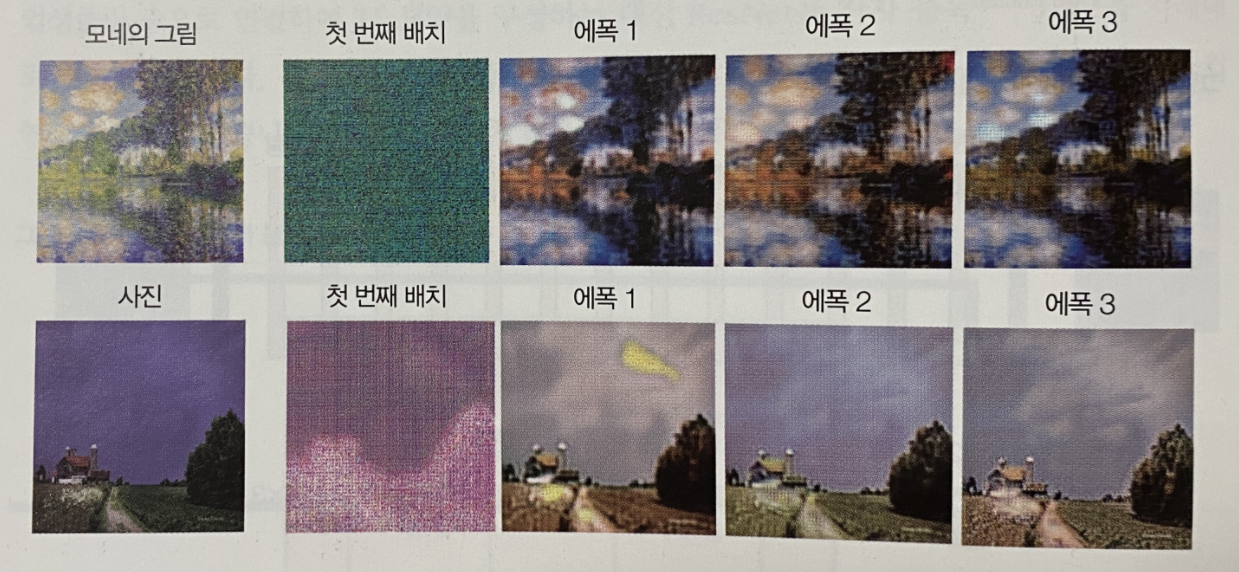

- 첫 번째 행은 모네가 사용한 특유의 색깔과 붓질을 사진에서 볼 수 있다.색은 자연스럽게, 경계선은 부드럽게 변하고 있다.


- 두 번째 행은 반대 현상이 발생한다.**모네가 직접 그린 것 같은 그림으로 사진을 변환하는 방법을 생성자가 배우게 된다.**

# 5.5. 뉴럴 스타일 트랜스퍼

지금까지 CycleGAN이 어떻게 두 도메인 사이에서 이미지를 변환하는지 알아보았다.

훈련 세트의 이미지는 짝을 이룰 필요가 없다. 

이제 훈련 세트를 사용하지 않고 이미지의 스타일을 다른 이미지로 전달하는 **뉴럴 스타일 트랜스퍼**에 대해 알아보자.

**뉴럴 스타일 트랜스퍼**는 세 부분으로 구성된 손실 함수의 가중치 합을 기반으로 작동한다.

1) **콘텐츠 손실(content loss)** : 합성된 이미지는 베이스 이미지의 콘텐츠를 동일하게 포함해야 한다.

2) **스타일 손실(style loss)** : 합성된 이미지는 스타일 이미지와 동일한 일반적인 스타일을 가져야한다.

3) **총 변위 손실(total variation loss)** : 합성된 이미지는 픽셀처럼 격자 무늬가 나타나지 않고 부드러워야 한다.

- 경사하강법으로 이 손실을 최소화 한다. 즉, 많은 반복을 통해 손실 함수의 음의 그레이디언트 양에 비례하여 픽셀값을 업데이트한다.

    => 반복이 진행됨에 따라 손실은 점차 줄어들어 베이스 이미지의 콘텐츠와 스타일 이미지를 합친 합성 이미지를 얻게 될 것
    

- 경사하강법으로 출력을 최적화하는 것은 지금까지 다루었던 생성 모델링 문제와는 다르다. 여기에서는 베이스 이미지와 스타일 이미지 두 개만 가지고 있기에 오차를 역전파 시켜 훈련 세트에서 학습한 정보를 일반화하여 새로운 이미지를 생성할 수 없다.


- 사전 훈련된 심층 신경망을 사용해 손실 함수에 필요한 이미지에 관한 중요한 정보를 얻는다. 

## 5.5.1 콘텐츠 손실

**콘텐츠 손실**은 콘텐츠의 내용과 전반적인 사물의 배치 측면에서 두 이미지가 얼마나 다른지를 측정한다. 

비슷한 장면을 담은 두 이미지는 완전히 다른 장면을 포함하는 두 이미지보다 손실이 작아야 한다.

두 이미지의 픽셀값을 비교하는 것만으로는 부족하다. 두 이미지의 장면이 같더라도 개별 픽셀값이 비슷할 것으로 기대할 수 없기 때문이다.

콘텐츠 손실은 개별 픽셀값과 무관해야하며 건물, 하늘, 강과 같은 고차원 특성은 존재와 대략적인 위치를 기반으로 이미지를 점수화 해야한다.

**베이스 이미지와 현재 합성된 이미지에 대해, 주어진 이미지에 대한 높은 수준의 특성을 추출하는 훈련된 신경망의 출력을 계산하여 그 사이의 평균 제곱오차를 측정하면 콘텐츠 손실함수가 된다.**

여기서 사용할 사전 훈련된 네트워크는 VGG19이다. 

ImageNet 데이터셋에 있는 백만 개 이상의 이미지를 천 개 이상의 범주로 분류하도록 훈련된 19개의 층을 가진 합성곱 신경망이다.

In [ ]:
# 콘텐츠 손실 함수

from keras.applications import vgg19
from keras import backend as K

base_image_path = '/path_to_images/base_image.jpg'
style_reference_image_path = '/path_to_images/styled_image.jpg'

content_weight=0.01

# 베이스 이미지와 스타일 이미지를 위한 두 개의 케라스 변수와 생성된 합성 이미지를 담을 플레이스 홀더 정의
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1,img_nrow,img_ncols,3))  
input_tensor = K.concatenate([base_image,style_reference_image, combination_image],axis=0) # 세 이미지를 연결하여 VGG19 모델의 입력 텐서를 만듦

model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False) # include_top은 네트워크의 마지막 완전 연결 층의 가중치를 사용하지 않는다는 의미. 여기서 관심있는 것은 입력 이미지에 대한 고수준 특성을 감시하는 합성곱 층이기 때문

outputs_dict = dict([(layer.name,layer.output) for layer in model.layers])
layer_features = outputs_dict['block5_conv2']  # 콘텐츠 손실을 계산하기 위해 사용한 층은 다섯번째 블록의 두 번째 합성곱 층

base_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]  # VGG19 네트워크에 주입된 입력 텐서에 베이스 이미지 특성과 합성 이미지 특성을 추출

def content_loss(content,gen):
    return K.sum(K.square(gen-content))

content_loss = content_weight * content_loss(base_image_features, combination_image_features)  # 두 이미지에 대한 층의 출력 간에 거리 제곱 합을 계산하고 가중치 파라미터 곱하여 콘텐츠 손실 얻음

## 5.5.2 스타일 손실

- 스타일 손실은 조금 더 계산하기 어렵다. 


- **스타일 손실** : 합성된 이미지는 스타일 이미지와 동일한 일반적인 스타일을 가져야한다.

     => 어떻게 두 이미지 사이에 있는 스타일 유사도 측정?
    
    
- 해결책은 스타일이 비슷한 이미지는 특정 층의 특성 맵 사이에 동일한 상관관계 패턴을 가진다는 아이디어를 기반으로 한다.

두 개의 특성 맵이 얼마나 동시에 활성화되는지 수치적으로 측정하려면 특성 맵을 펼치고 스칼라곱 (또는 점곱)을 계산한다.

계산된 값이 크면 특성 맵 사이의 **상관관계가 크고**, 값이 작으면 특성 맵 사이의 **상관관계가 없다.**

층에 있는 모든 특성 사이의 스칼라곱을 담은 행렬을 정의할 수 있는데 이를 **그람 행렬(gram matrix)** 라고 불린다.

콘텐츠가 많이 다르더라도 층의 모든 특성 맵 간 상관관계를 측정한 그람 행렬은 비슷할 수 있다.

따라서 스타일 손실을 계산하려면 **베이스 이미지와 합성된 이미지에 대해 네트워크의 여러층에서 그람 행렬을 계산해야 한다.**

그 다음 두 그람 행렬의 제곱 오차 합을 사용하여 유사도를 비교한다.

베이스 이미지(S)와 생성된 이미지(G) 사이의 스타일 손실은 크기가 M_l(높이 * 너비) 이고 N_l개의 채널을 가진 층(l)을 이용해 다음과 같은 수식으로 쓸 수 있다.

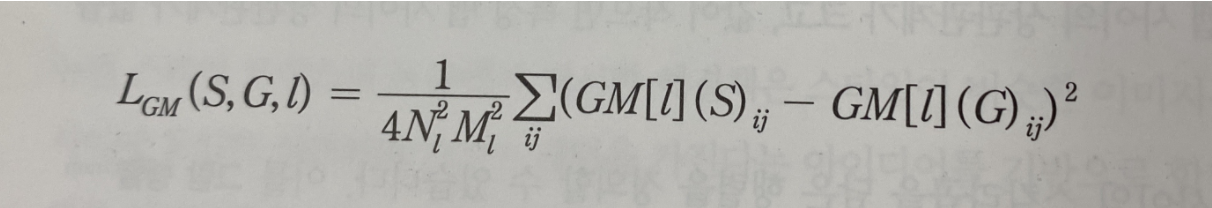

두 이미지의 전체 스타일 손실은 크기가 다른 여러 층에서 계산한 스타일의 가중치 합이다. 채널 수(N_l)와 층의 크기(M_l)로 스케일을 조정해 다음과 같이 계산한다.

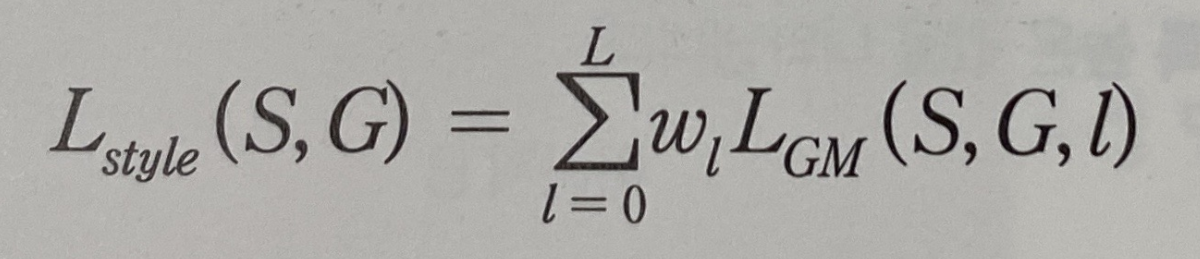

In [ ]:
# 스타일 손실 함수

style_loss = 0.0

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))  # permute는 인풋의 차원을 변경하는 것인듯
    gram = K.dot(features,K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C= gram_matrix(combination)
    channels=3
    size=img_nrows *img_ncols
    return K.sum(K.square(S-C)) / (4.0*channels**2)*(size**2)

feature_layers = ['block1_conv1','block2_conv1',
                 'block3_conv1','block4_conv1','block5_conv1']  # 5개 층에서 스타일 손실 계산

for layer_name in feature_layers :
    layer_features = output_dict[layer_name]
    style_reference_features = layer_features[1,:,:,:]  # VGG19 네트워크로 주입된 입력텐서에서 스타일 이미지의 특성맵과 합성된 이미지의 특성맵 추출
    combination_features = layer_features[2,:,:,:]
    sl = style_loss(style_reference_features,combination_features)
    style_loss+=(style_weight / len(feature_layers)) *sl  # 가중치 파라미터와 계산에 참여한 층의 갯수로 스타일 손실의 스케일을 조정

## 5.5.3 총 변위 손실

**총 변위 손실은 단순히 합성된 이미지에 있는 잡음을 측정한 것이다.**

이미지의 잡음을 측정하기 위해 오른쪽으로 한 픽셀 이동하고 원본 이미지와 이동한 이미지 간의 차이를 제곱하여 더한다.

균형을 맞추기 위해 동일한 작업을 한 픽셀 아래로 이동하여 수행한다. 이 두항의 합이 총 변위 손실이다.

In [ ]:
# 변위 손실 함수

def total_variation_loss(x):
    a=K.square(x[:,:img_nrows-1,:img_ncols-1,:]-[x:,:,img_ncols-1,:])  # 한 픽셀 아래로 이동한 후 차이를 계산하여 제곱
    b=K.square(x[:,:img_nrows-1,:img_ncols-1,:]-[x:,:,img_ncols-1,1:,])  # 한 픽셀 오른쪽으로 이동한 후 차이를 계산하여 제곱
    return K.sum(K.pow(a+b,1.25))

tv_loss = total_variation_weight * total_variation_loss(combination_image)  # 가중치를 곱해서 총 변위 손실을 계산

loss = content_loss + style_loss + tv_loss   # 전체 손실은 콘텐츠 손실, 스타일 손실, 총 변위 손실의 합

## 5.5.4 뉴럴 스타일 트랜스퍼 실행

학습 과정은 이 손실 함수를 최소화하기 위해 합성된 이미지의 픽셀에 대해 경사 하강법을 실행하는 것이다. 

In [ ]:
# 뉴럴 스타일 트랜스퍼 모델의 훈련 반복

from scipy.optimize import fmin_l_bfgs_b

iterations = 1000
x=preprocess_image(base_image_path)  # 베이스 이미지로 초기 합성된 이미지를 초기화

for i in range(iterations):  # 반복마다 현재 합성된 이미지를 일렬도 펼쳐서 최적화 함수로 전달. 이 함수는 L-BFGS-B알고리즘 사용하여 경사하강법의 한 스텝을 수행
    x,min_val,infor = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads,maxfun=20)  # evaluator는 전체 손실과 입력 이미지에 대한 손실의 그레이디언트를 계산하기 위한 메서드를 가진 객체

# 5.6 요약

- 이 장에서는 새로운 그림을 생성하는 방법인 **CycleGAN**과 **뉴럴 스타일 트랜스퍼**를 살펴보았다.


- CycleGAN 방법으로 모델을 훈련하여 아티스트의 일반적인 스타일을 학습하고 사진에 이를 옮길 수 있다(마치 아티스트가 사진에 있는 장면을 그린 것 같은 결과를 만들어낸다).

    => 이 모델은 그림을 실제 사진으로 바꾸는 반대 과정도 자동으로 만든다. 
    
***CyCleGAN에서는 각 도메인의 이미지 쌍이 필요하지 않으므로 매우 강력하고 유연한 기술이라는 점이 중요하다.***

- 뉴럴 스타일 트랜스퍼를 사용하면 한 이미지의 스타일을 베이스 이미지로 옮길 수 있다.


- 베이스 이미지의 콘텐츠에서 크게 벗어나지 않도록 적절히 선택한 손실 함수와 스타일 이미지의 스타일을 사용한다( 결과 이미지의 품질은 어느정도 유지한다 ).

    => 이 기술은 잘 알려진 여러 상용 애플리케이션에서 사용자의 사진과 독특한 스타일을 가진 그림을 섞기 위해 사용된다.
    

- 다음 장은 이미지 기반의 생성 모델링에서 벗어나 새로운 도전 과제인 텍스트 기반의 생성 모델링 영역에 대해 알아볼 것이다.